# Playing with Plotting  

What follows includes some exercises/challenges related to plotting and displaying data in Python. 

The goal is to provide an opportunity to play with different types of data and explore ways of displaying it. You don't need to do every single exercise, and you don't need to do them all today. Hopefully this can serve as a useful reference for future work. 

There are multiple ways to do each of these, and everyone has their favorite. There are no 'right' answers.

The exercies that follow relate to:  
- [1D spectra](#1dspectra)
- [Scatter plots](#scatter)
- [Images](#image)
- [Random Tricks](#tricks)

---

<a id='1dspectra'></a>

## 1D spectra

In this directory is a 1d spectrum from SDSS of a z~0.076 star-forming galaxy.  
The same spectrum is available in two file formats: `spec.dat` and `spec.fits`  

The wavelength is in units of $A$ and the flux and flux error are in units of $10^{-17}$ erg/s/cm$^2$/$A$

**Read in the spectrum**  
Options include `numpy.genfromtxt`, `astropy.table.Table`, `astropy.io.fits`

In [3]:
#Start by importing everything you'll need
import numpy as np #essential
import astropy #not particularly essential
from astropy import constants as const #essential for common scientific naming constants with shorthand 
#http://docs.astropy.org/en/stable/constants/ 
from astropy import units as u #useful for units https://docs.astropy.org/en/stable/units/
from astropy.io import fits #essential for loading and manipulating .fits files
import matplotlib.pyplot as plt #essential for plotting. there are some depricated modules

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation) #this entire chunk is just to ignore an 
#annoying warning about a deprecated matplotlib command that i never use. 

from scipy import integrate #The SciPy ecosystem, a collection of open source software for scientific computing 
#in Python. https://www.scipy.org/about.html. this imports some mid-level integration functions
from scipy.stats import norm #To fit a Gaussian, simply use norm.fit(data). This will return the mean and 
#standard deviation of the fit. np.average() and np.std() will give the mean and standard deviation of the actual data.
from scipy import optimize as opt #this is for optimizing curves based on found variables
from scipy.interpolate import interp1d #"interpolate" is a fancy word for "connect the dots". this is useful for
#seeing connections and shapes in data points


import math #there are some extremely intuitive shorthand mathematical functions here
import aplpy #aplpy lets you plot .fits figures

wave, flux, err = np.genfromtxt('spec.dat').T #this gives the individual data in a big table. there's enough that 
#it wont display it all, but if you print it, you will see it is organized into three columns. numpy tries to read
#this as one giant column, so the .T at the end of the genfromtxt command tells it to transpose..this really should
#be the default...
print(data)
speclist = hdulist = fits.open('spec.fits')
hdulist.info() #this line shows metadata about the file. you can see that it confirms the number of columns in the file

NameError: name 'data' is not defined

**Plot the spectrum including errors**

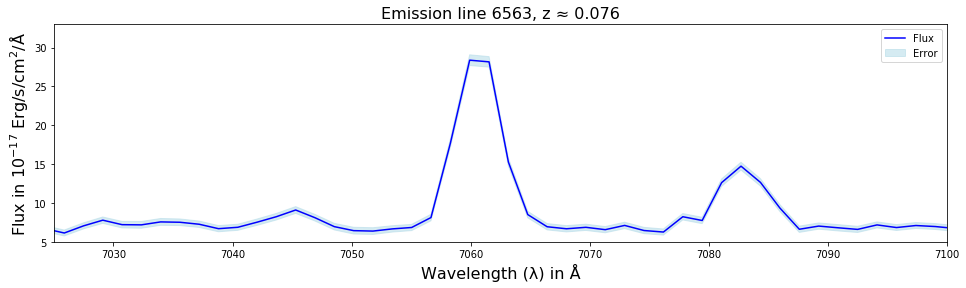

In [87]:
plt.figure(figsize=(16, 4)) #we want to put this command here because otherwise it splits the figure up into two 
#pieces, the plot and the error plot
plt.plot(wave, flux, label='Flux', color='b') #for some reason it wants to use a lowercase L in the word 'label' or else it 
#wont display. idk. whatever

plt.fill_between(wave, flux + err, flux - err, color='lightblue', label='Error', alpha=0.5) #oscar and i worked this out but i dont like 
#it to make this filled in error bar, we must plot x as the line, y1 as the area above, and y2 as the area below
#we need to make sure to choose colors that contrast a good deal

plt.xlim(7025, 7100)
plt.ylim(5, 33) #this method of showing error bars seems to work best only in a very small region of the plot
plt.xlabel('Wavelength (λ) in Å', fontsize=16)
plt.ylabel('Flux in 10$^{-17}$ Erg/s/cm$^2$/Å', fontsize=16) #The erg is a unit of energy and work equal to 10⁻⁷ joules
#adding superscript and subscript is done one character at a time. for instance $^-17$ will not give a -17 superscript
#but rather a - superscript followed by a regular sized 17. each character must be superscripted individually
#subscript is done with $_character$ eg. $_2$ will yield a subscript 2. much easier to say $^{-17}

plt.legend()
plt.title('Emission line 6563, z ≈ 0.076', fontsize=16)
plt.show()

**Measure emission line fluxes**  

In this spectrum, there is an H$\alpha$ emission line at 6563 $A$ $\times$ $(1+z)$. What is the flux of this line?

Consider trying:
- directly integrating the flux of the line (you might explore one of the modules in `scipy.integrate`)
- fitting a Gaussian to the line (maybe `scipy.optimize.curve_fit`)

and comparing the fluxes you get with either method

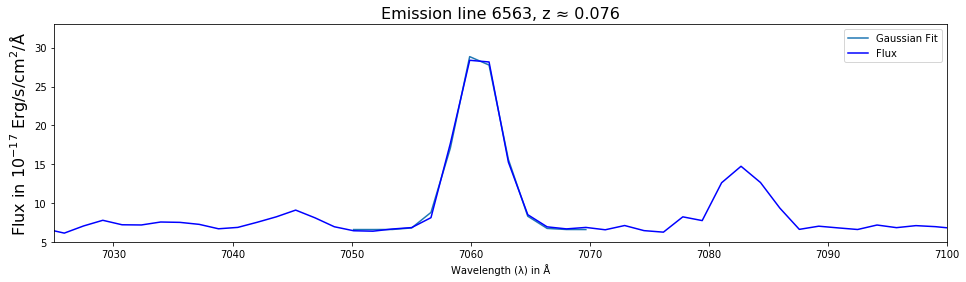

In [111]:
#What i need to do is fit the gaussian between a range. if it simply fit a gaussian to the plot, it's going to give
#me an average over the entire spectrum. i really dont want that. i think i know how to do this...
#here's what i could do: i bet i can assign a variable to a range of wavelengths centered on 6563, and fit a gaussian
#curve to that range...remember that its redshifted by some amount. the spike is at 7059.923 = 6563*(1+z)
#>> (1 + z) = 7059.923/6563 >> z ≈ 0.0757. i remembered as soon as i finished doing the algebra myself that Micaela 
#gave us was z ≈ 0.076. if i centered on 7059.923, and went 10 up and down, my range is from 7049.923-7069.923 Å. 

#fig = plt.figure()
plt.figure(figsize=(16, 4))

w1 = 7059.923 - 10
w2 = 7059.923 + 10
wave_range = np.where((wave >= w1) & (wave <= w2)) #wave is not a list, but an array. in order to select values from 
#this array, we use the numpy 'where' command. and vs & are different things..& joins two conditions, the word 'and' 
#is seldom used, and means something else. 

wx = wave[wave_range] #we're telling it to choose the wave_range from within the wave array. assigning variables to
#this allows us to avoid having to use indices
fy = flux[wave_range] #we're assigning these variables because we're going to be using them to optimize the fit


def gauss(x, mu, sig, f0, cont):
    myexp = np.exp(- (x - mu)**2 / (2 * sig**2) )
    return f0 * myexp + cont #we still need to define our gaussian with some parameters. this function is smart enough
#to read the variables we gave it in order, and uses our initial parameter guess 'p0' to try to make those guesses
#line up. note that we have added a parameter, cont = 6, to account for the fact that the curve does not begin at zero,
#but rather has a continuum around where the y-axis = 6. we've ordered it so that it always comes last, and made sure
#to add it with the '+ cont' step in the return line of the function. from now on, we must be sure to assign it last

bfpar, covar = opt.curve_fit(gauss, wx, fy, p0=[7059.923, 1, 28.38551, 6]) #to optimize the fit, we need
#the name of the defined function, the x & y range of values to be tested, and our initial parameter guess.
#mu = 7059, sigma=1, f0=28, & cont = 6 these are all in the same order we wrote them in the definition of the function
myfit = gauss(wx, bfpar[0], bfpar[1],  bfpar[2], bfpar[3]) #starting with index 0, these are the best fit parameters
#associated with mu, sigma, flux, and the continuum

plt.plot(wx, myfit, label='Gaussian Fit')
plt.plot(wave, flux, label='Flux', color='b')
plt.xlabel('Wavelength (λ) in Å', fontsize=10)
plt.ylabel('Flux in 10$^{-17}$ Erg/s/cm$^2$/Å', fontsize=16)

plt.legend()
plt.title('Emission line 6563, z ≈ 0.076', fontsize=16)
plt.xlim(7025, 7100)
plt.ylim(5, 33)
#plt.savefig('Emission_Line_Chart')
plt.show()

**Bonus: try fitting other profiles to the line, such as a Lorentzian or Voight profile**

In [6]:
import fibo

ModuleNotFoundError: No module named 'fibo'

---
<a id='scatter'></a>

## Scatter plots

In this directory there is another file `galSpecSubset-dr8.fits` containing some measurements from spectra for a subset of the [MPA-JHU value-added SDSS catalog](https://www.sdss.org/dr12/spectro/galaxy_mpajhu/). These measurements were released for SDSS data release 8 and are named after the Max Planck Institute for Astrophysics and the Johns Hopkins University where the measurement technique was developed (see [Brinchmann et al. 2004](http://adsabs.harvard.edu/abs/2004MNRAS.351.1151B), [Kauffmann et al. 2003](http://adsabs.harvard.edu/abs/2003MNRAS.341...33K), and [Tremonti et al. 2004](http://adsabs.harvard.edu/abs/2004ApJ...613..898T)).

The subset of data here includes
- `logmass`: log$_{10}$(mass [$M_{\odot}$]),
- `logsfr`: log$_{10}$(star formation rate [$M_{\odot}$/yr]), and 
- `haflux`: H$\alpha$ line flux in units of $10^{-17}$ erg/s/cm$^2$/$A$ 

for ~0.3% of the full catalog. 

**Create a scatter plot showing `logmass` vs `logsfr`. Color-code your points by `haflux`**

**Use a logarithmic color scaling (and colorbar) for the `haflux` values**

**Plot a histogram of `haflux` values**

**Plot `logmass` vs `logsfr` as a 2D histogram**

**Plot `logmass` vs `logsfr` vs `haflux` as a 3D scatter plot**

_Hint:_   
`from mpl_toolkits.mplot3d import Axes3D`  
`fig = plt.figure()`  
`ax = fig.add_subplot(111, projection='3d')`

**Find all points that lie in a specific region**

There is a table of random x and y values called `random_scatter.fits`.

- How many/which points are within a circle centered at (0,0.4) with a radius of 0.2?
- How many/which points are within a square centered at the same point with side length 0.2?
- How many/which points are within the polygon defined by the corners: [-1.3,0.8], [0.7,0.6], [0.4,0.3], [-1,0.5]? 

---
<a id='image'></a>

## 2D Images

There are 5 images in fits format: `image1.fits`, etc. Each one contains an image of a source with some cool structure. The full extent of the structure will not be visible until you find an optimal stretch and scaling for displaying the image. 

Pick an image at random or play with all of them! `image5.fits` is a particular challenge because of nearby bright sources/artifacts in the image. 

**Display the image**

If you're using `matplotlib`:  
`plt.imshow(...)`  
And remember that you need the keyword `origin='lower'` to place the [0,0] index of the array in the lower left corner like our brains usually want.

**Change color maps, play with changing the vmin,vmax scaling**

**`astropy.visualization` includes some very useful functions for optimal stretching/scaling of image data**

**Bonus: display a ds9 region on top of the image**

There's a ds9 regions file (`ds9.reg`) with two regions: a green square and a blue circle.    
Use `pyregion` to display both regions on top of the image.

**Bonus: display the image with WCS coordinates/axes**

_Hint:_  
`astropy.wcs.WCS` will get all the WCS information (RA,Dec, etc.) from the header. You can create a subplot with a `wcs` projection (similar to the `3d` projection above, but with the WCS defined in the image header)


---
<a id='tricks'></a>

## Random Tricks

An assortment of random tricks

**Defining a figure**  
Defining an instance of a Figure object gives you more control over plotting options than making all plotting commands with `plt`. 

You can define a figure:  
`fig = plt.figure()`  
Then add an axis:  
`ax = fig.add_subplot(111)`  
And to plot to the axis:  
`ax.plot(...)`

You can create a figure and grid of axes all in one go:  
`fig,(ax1,ax2) = plt.subplots(1, 2)`

Setting `tight_layout` will make pyplot optimize the placement of all your axes automatically:  
`fig,(ax1,ax2) = plt.subplots(1, 2, tight_layout=True)`  
or:  
`plt.tight_layout()`

Defining a figure lets you save it to disk:  
`fig.savefig('figure.png')`  
`fig.savefig('figure.pdf')`

**Iterate through a colormap**  
If you are plotting several lines in a for loop, you can iterate through a colormap so each line has a different color without explicitly having to define each one: 

```
from matplotlib.pyplot import cm  
import numpy as np  

# let nlines be the number of lines you have to plot  
colors = iter(cm.magma(np.linspace(0,1,nlines)))  
for thing in things_to_plot:  
    c = next(colors)  
    plt.plot(x, y, c=c)
```

**Iterate through plotting symbols**  
In a similar way you can iterate through markers when making a scatter plot (or a line plot with markers):

```
import itertools
marker = itertools.cycle(('s', '+', '.', 'o', '*')) 
for thing in things_to_plot:
    plt.scatter(x, y, marker=next(marker))
```

**Create your own plot symbol**  
For example, to create an upper limit arrow:  

```
import numpy as np
from matplotlib.path import Path


def upper_limit():
    """Create a marker for an upper limit - empty box with arrow"""
    verts = [(0,2),(2,2),(2,-2),(-2,-2),(-2,2),(0,2),
             (0,7.5),(2.5,5.5),(0,7.5),(-2.5,5.5),(0,7.5),(0,2)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO,
             Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO,
             Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    return path
    
plt.scatter(x, y, marker=upper_limit(), s=800)
plt.plot(x, y, marker=upper_limit(), ms=30)
```
(You have to scale up the size of the symbol)

**Use an image as a plot symbol**  
Can we make a scatter plot of JWST mirrors? Why, yes we can!  

```
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

xx = [0,1,2,3,4]
yy = [0,1,2,3,4]

fig, ax = plt.subplots()
ax.plot(xx, yy)
# read in the image
image = plt.imread('mirror.png')
# we have to scale down the image size (or use a different coordiate system for display)
im = OffsetImage(image, zoom=0.05)
for x,y in zip(xx,yy):
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)
```